# Notebook 02 – Veri Görselleştirme ve Karşılaştırmalı Analiz

Bu notebook’ta, Notebook_01’de incelenen elektrik tüketimi ve
tahsilat verileri kullanılarak ilçeler, hesap sınıfları ve zaman
boyutunda karşılaştırmalı analizler ve veri görselleştirmeleri
yapılmıştır.

In [292]:
# necessary libraries
import numpy as np  # numerical operations 
import pandas as pd  # data manipulation 
import seaborn as sns  # visualization
import matplotlib.pyplot as plt  # visualization

# Temizlenmiş veri setlerinin Parquet formatından hızlı bir şekilde yüklenmesi
df_tahsilat = pd.read_parquet("df_tahsilat_clean.parquet")
df_tahsilat_1 = pd.read_parquet("df_tahsilat_1_clean.parquet")
df_tahakkuk = pd.read_parquet("df_tahakkuk_clean.parquet")

In [16]:
# first 5 rows of the data
df_tahsilat_1.head()

,Mali yıl/dönem,İl,İlçe,Söz.hsp.(bağımsız),Hesap Sınıfı,Tahakkuk Tutar,Son Ödeme Tarihinden Önceki Tahsilat,Son Ödeme Tarihindeki Tahsilat,Son Ödeme (1),Son Ödeme (2),...,Son Ödeme (5),Son Ödeme (6-10),Son Ödeme (10-20),Son Ödeme (20-30),Son Ödeme (30-60),Son Ödeme (60-90),Son Ödeme (90-120),Son Ödeme (120-150),Son Ödeme (150-180),Son Ödeme (180+)
0,2023-01-01,AMASYA,GÖYNÜCEK,9374624783,Mesken,5.03,0.03,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
1,2023-01-01,AMASYA,GÖYNÜCEK,236184905,Mesken,26.46,0.06,26.40,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-01,AMASYA,GÖYNÜCEK,9657731015,Mesken,121.53,NaN,NaN,NaN,121.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-01,AMASYA,GÖYNÜCEK,9554442880,Mesken,117.49,NaN,117.49,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-01,AMASYA,GÖYNÜCEK,6031642522,Mesken,170.30,170.30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Yüklenen tüm veri setlerinin teknik özetlerinin ve veri tiplerinin incelenmesi
for dataframe in [df_tahsilat, df_tahsilat_1, df_tahakkuk]:
    dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636993 entries, 0 to 636992
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Şube                   636993 non-null  category      
 1   Kasa                   636993 non-null  category      
 2   İlçe                   636993 non-null  category      
 3   Söz.hsp.(bağımsız)     636993 non-null  object        
 4   Tahsilat Tarihi        636993 non-null  datetime64[ns]
 5   Nakit Tahsilat         523 non-null     float64       
 6   Mahsuben Tahsilat      7542 non-null    float64       
 7   Kredi Kartı Tahsilatı  0 non-null       float64       
 8   Banka Tahsilatı        628933 non-null  float64       
dtypes: category(3), datetime64[ns](1), float64(4), object(1)
memory usage: 31.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917632 entries, 0 to 917631
Data columns (total 22 columns):
 #   Column                       

#### Problem Tanımı
İlçeler arasında abone profillerinin benzer olup olmadığını
anlamak amacıyla hesap sınıfı dağılımları karşılaştırılmıştır.

In [72]:
# Tahakkuk veri setinde yer alan benzersiz ilçeler
tahakkuk_ilceleri = df_tahakkuk['ilce'].unique()

print(f"Tahakkuk tablosundaki ilçeler: {tahakkuk_ilceleri}")

Tahakkuk tablosundaki ilçeler: ['HAMAMÖZÜ', 'GÜMÜŞHACIKÖY', 'GÖYNÜCEK']
Categories (3, object): ['GÖYNÜCEK', 'GÜMÜŞHACIKÖY', 'HAMAMÖZÜ']


In [274]:
# Tahakkuk veri setindeki her bir ilçe için benzersiz müşteri sayıları
for ilce_adi in tahakkuk_ilceleri:
    bu_ilce = df_tahakkuk[df_tahakkuk['ilce'] == ilce_adi]
    print(f"{ilce_adi} benzersiz müşteri sayısı: {bu_ilce['sozlesme_hesap_no'].nunique()}")

HAMAMÖZÜ benzersiz müşteri sayısı: 2981
GÜMÜŞHACIKÖY benzersiz müşteri sayısı: 18190
GÖYNÜCEK benzersiz müşteri sayısı: 7128


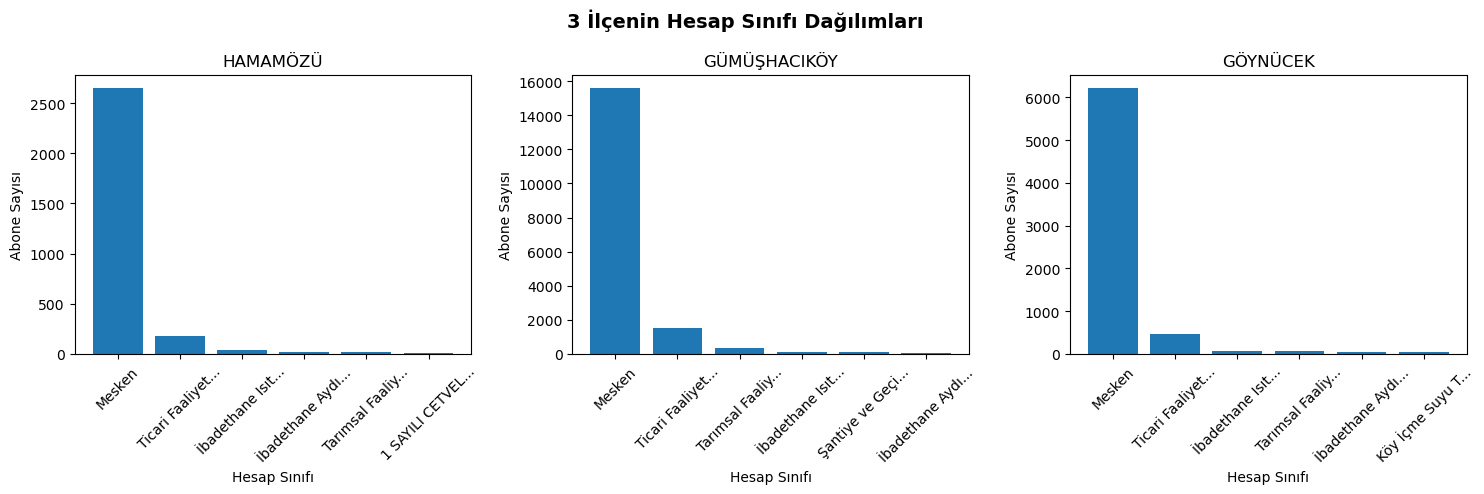

In [254]:
# =============================================
# HESAP SINIFI DAĞILIMLARI - 3 İLÇE YAN YANA

# İlçelerin hesap sınıfı dağılımlarının abone bazında karşılaştırmalı olarak görselleştirilmesi

def kisalt(x):
    return x[:15] + "..." if len(x) > 15 else x

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('3 İlçenin Hesap Sınıfı Dağılımları', fontsize=14, fontweight='bold')

for i, ilce_adi in enumerate(tahakkuk_ilceleri):
    # İlçeye göre tüm veriyi al
    bu_ilce = df_tahakkuk[df_tahakkuk['ilce'] == ilce_adi]

    # Benzersiz müşteriler (abone bazlı analiz)
    benzersiz_musteriler = bu_ilce.drop_duplicates(subset='sozlesme_hesap_no')

    # Hesap sınıfı sayımları
    hesap_sayilari = benzersiz_musteriler['Hesap Sınıfı'].value_counts().head(6)

    axes[i].bar(
        [kisalt(x) for x in hesap_sayilari.index],
        hesap_sayilari.values
    )
    axes[i].set_title(ilce_adi)
    axes[i].set_xlabel('Hesap Sınıfı')
    axes[i].set_ylabel('Abone Sayısı')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('ilce_hesapsınıf_dağılım.png')
plt.show()


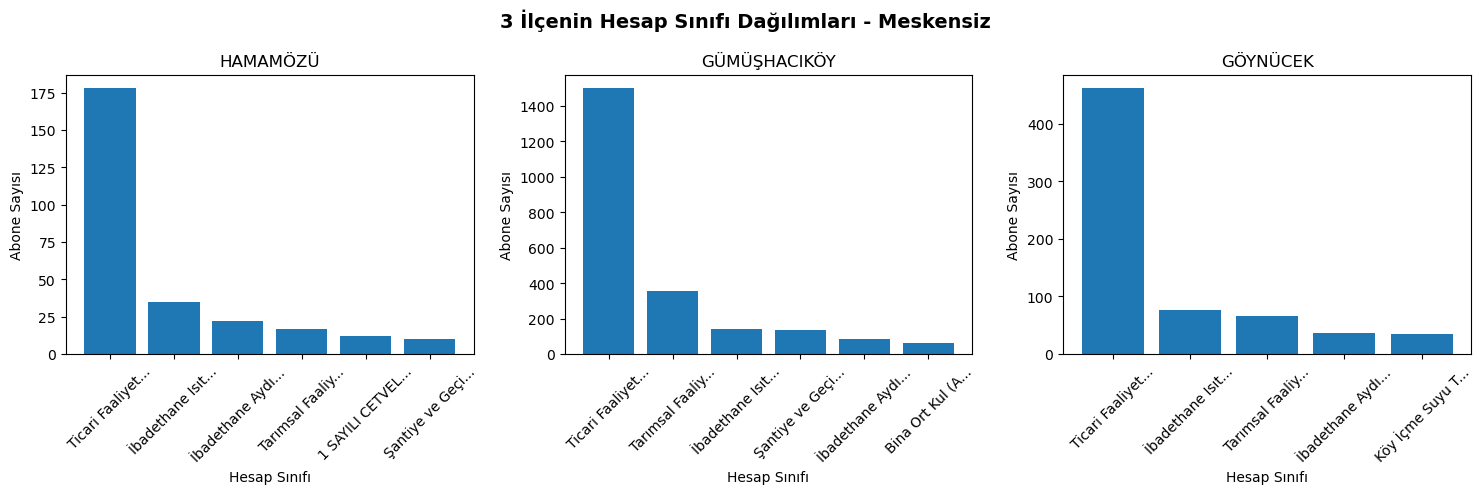

In [256]:
# ========================================================
# HESAP SINIFI DAĞILIMLARI - 3 İLÇE YAN YANA ( Meskensiz )

# İlçelerin hesap sınıfı dağılımlarının meskensiz olacak şekilde abone bazında karşılaştırmalı olarak görselleştirilmesi 

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('3 İlçenin Hesap Sınıfı Dağılımları - Meskensiz', fontsize=14, fontweight='bold')

for i, ilce_adi in enumerate(tahakkuk_ilceleri):
    # İlçeye göre tüm veriyi al
    bu_ilce = df_tahakkuk[df_tahakkuk['ilce'] == ilce_adi]

    # Benzersiz müşteriler (abone bazlı analiz)
    benzersiz_musteriler = bu_ilce.drop_duplicates(subset='sozlesme_hesap_no')

    # Hesap sınıfı sayımları
    hesap_sayilari = benzersiz_musteriler['Hesap Sınıfı'].value_counts().iloc[1:7]

    axes[i].bar(
        [kisalt(x) for x in hesap_sayilari.index],
        hesap_sayilari.values
    )
    axes[i].set_title(ilce_adi)
    axes[i].set_xlabel('Hesap Sınıfı')
    axes[i].set_ylabel('Abone Sayısı')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('ilce_meskensiz_dağılım.png')
plt.show()

İlçeler arasında abone sayılarının önemli ölçüde farklılık göstermesi,
grafikler üzerinden yapılan karşılaştırmaları zorlaştırmaktadır. Bu nedenle analizde, 
her ilçe için hesap sınıflarının toplam aboneler içindeki **oransal dağılımları** 
hesaplanmıştır.

Her ilçe özelinde hesap sınıfı oranları belirlendikten sonra, bu oranlar
kullanılarak ilçeler arası hesap sınıfı büyüklükleri karşılaştırılmıştır.
Bu yaklaşım sayesinde, abone sayısından bağımsız olarak ilçelerin
müşteri profilleri ve baskın hesap sınıfları daha sağlıklı bir biçimde
değerlendirilebilmiştir.

In [303]:
# ===================================
# HER İLÇE İÇİN HESAP SINIFI ORANLARI

# İlçe bazında benzersiz müşterilerin hesap sınıflarına göre yüzdesel dağılım raporunun oluşturulması

print("="*70)
print("İLÇELERE GÖRE HESAP SINIFI ORANLARI (BENZERSİZ MÜŞTERİLER)")
print("="*70)

# Her ilçe için oranları hesapla ve yazdır
for i, ilce_adi in enumerate(tahakkuk_ilceleri):
    # İlçeye göre tüm veriyi al
    bu_ilce = df_tahakkuk[df_tahakkuk['ilce'] == ilce_adi]
    
    # Benzersiz müşteriler (abone bazlı analiz)
    benzersiz_musteriler = bu_ilce.drop_duplicates(subset='sozlesme_hesap_no')
    
    # Hesap sınıfı sayımları
    hesap_sayilari = benzersiz_musteriler['Hesap Sınıfı'].value_counts().head(10)
    
    # Oranları hesapla (yüzde olarak)
    toplam_musteri = bu_ilce['sozlesme_hesap_no'].nunique()
    oran = (hesap_sayilari / toplam_musteri) * 100
    
    
    print(f"\n{ilce_adi.upper()}")
    print("-"*70)
    for hesap_sinifi, yuzde in oran.items():
        print(f"{hesap_sinifi:30} -> ({yuzde:6.1f}%)")

print("="*70)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.======================================================================
İLÇELERE GÖRE HESAP SINIFI ORANLARI (BENZERSİZ MÜŞTERİLER)


HAMAMÖZÜ
----------------------------------------------------------------------
Mesken                         -> (  88.9%)
Ticari Faaliyet - Yazıhane     -> (   6.0%)
İbadethane Isıtma/Soğutma/Lojman -> (   1.2%)
İbadethane Aydınlatma          -> (   0.7%)
Tarımsal Faaliyetler (Şahıs)   -> (   0.6%)
1 SAYILI CETVELDE YER ALAN KAMU İDARESİ -> (   0.4%)
Şantiye ve Geçici Aboneler     -> (   0.3%)
Resmi Daire Lojman             -> (   0.3%)
Bina Ort Kul (Asn,Hidr,Kapıcı Dai vb.) -> (   0.2%)
Resmi Üniversite,Yük.Okul,Kurs,Yurt,Okul -> (   0.2%)

GÜMÜŞHACIKÖY
----------------------------------------------------------------------
Mesken                         -> (  85.7%)
Ticari Faaliyet - Yazıhane     -> (  

#### İlçelere Göre Hesap Sınıfı Oranları (Benzersiz Müşteriler)

**Hamamözü** ilçesinde mesken aboneleri %88,9 ile açık ara
baskın durumdadır. Ticari faaliyetler %6,0 oranında ikinci
sırada yer alırken, ibadethane ve tarımsal faaliyetlere ait
abonelerin toplam içindeki payı oldukça sınırlıdır.

**Gümüşhacıköy** ilçesinde mesken abonelerinin oranı %85,7 olup,
diğer ilçelere kıyasla ticari faaliyetlerin payının (%8,2)
bir miktar daha yüksek olduğu görülmektedir. Tarımsal faaliyetler
ve şantiye/geçici aboneler gibi sınıflar düşük oranlarla
dağılımı tamamlamaktadır.

**Göynücek** ilçesinde ise mesken aboneleri %87,2 oranında
baskın olup, ticari faaliyetler %6,5 seviyesindedir.
İbadethane ve tarımsal faaliyetlere ait abonelerin oranları,
diğer ilçelerle benzer şekilde düşük seviyelerde seyretmektedir.
Bu ilçede ayrıca köy içme suyu temini ve dağıtımı tesislerine
ait abonelerin küçük bir paya sahip olduğu görülmektedir.


### Bulgular

İlçeler bazında hesap sınıfı dağılımları incelendiğinde, tüm ilçelerde mesken abonelerinin baskın olduğu görülmektedir.
Bununla birlikte **Gümüşhacıköy** ilçesinde **Şantiye ve Geçici** abonelerinin oranının **Hamamözü**'nde **1 Sayılı Cetvel** abonalerinin **Göynücek**'te ise **Köy İçme Suyu T..** abonelerinin oranının diğer ilçelere kıyasla daha yüksek olduğu gözlemlenmiştir.

#### Problem Tanımı

Elektrik tüketiminin yıl içerisinde mevsimsel bir değişim gösterip
göstermediğini ve bu eğilimin ilçeler arasında farklılık içerip
içermediğini analiz etmek amaçlanmıştır.

#### Yeni Sütun Oluşturulması

Tahakkuk veri seti birden fazla yıla ait aylık ortalama kWh
değerlerini içermektedir. Yıllar arası farktan bağımsız olarak
aylık tüketim davranışlarını analiz edebilmek amacıyla,
tarih bilgisinden yalnızca ay bilgisini içeren **"ay"** adlı
yeni bir sütun oluşturulmuştur.

Bu sayede, farklı yıllara ait veriler bir araya getirilerek
her ay için ortalama kWh tüketimleri hesaplanabilmiş ve
mevsimsel tüketim eğilimleri daha sağlıklı bir şekilde
incelenebilmiştir.   

In [286]:
# Mali yıl/dönem tarih verisinden ay bilgisinin sayısal olarak ayıklanması ve yeni bir sütun olarak eklenmesi
df_tahakkuk['ay'] = df_tahakkuk['mali_yil_donem'].dt.month

In [290]:
# Aylık bazda ortalama kWh tüketim değerlerinin hesaplanması
aylik_ortalama = (
    df_tahakkuk
    .groupby(['ay'], observed=True)
    .agg(ort_kWh=('kwh', 'mean'))
    .reset_index()
)
aylik_ortalama.round(2)

,ay,ort_kWh
0,1,83.81
1,2,77.38
2,3,84.45
3,4,87.37
4,5,81.06
5,6,106.90
6,7,133.85
7,8,113.04
8,9,88.83
9,10,81.14


Bu tabloda, ortalama elektrik tüketiminin mevsimler arasında
belirgin şekilde değişkenlik gösterdiği gözlemlenmiştir.
Özellikle yaz aylarında ortalama tüketim değerlerinin artması,
mevsimsel faktörlerin elektrik kullanım davranışları üzerinde
etkili olduğunu ortaya koymaktadır.

In [287]:
# İlçe ve ay bazında ortalama kWh tüketim değerlerinin gruplandırılarak hesaplanması
ilce_aylik_ortalama = (
    df_tahakkuk
    .groupby(['ilce', 'ay'], observed=True)
    .agg(ort_kWh=('kwh', 'mean'))
    .reset_index()
)
ilce_aylik_ortalama.head()

,ilce,ay,ort_kWh
0,GÖYNÜCEK,1,71.727193
1,GÖYNÜCEK,2,66.219465
2,GÖYNÜCEK,3,75.583227
3,GÖYNÜCEK,4,79.906542
4,GÖYNÜCEK,5,77.440839


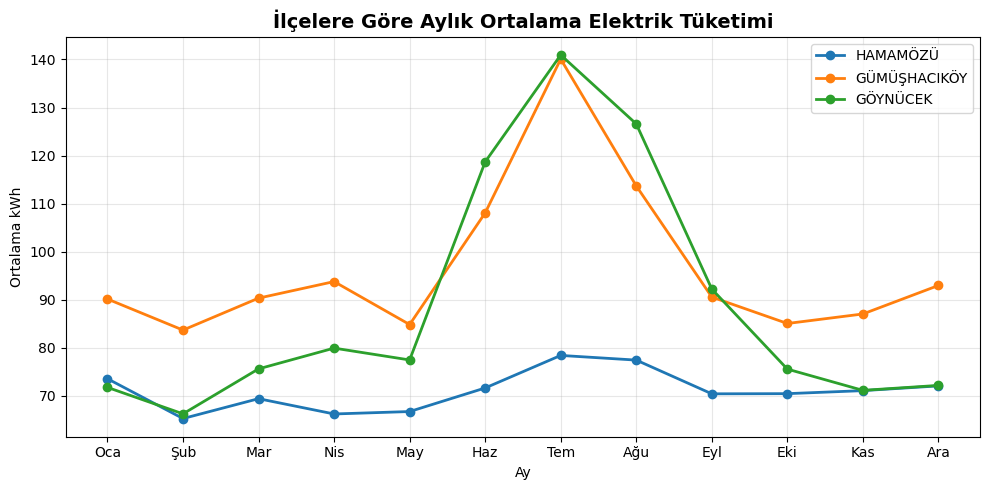

In [288]:
# ===================================
# AYLIK ORTALAMA TÜKETİM - ÇİZGİ GRAFİĞİ

# İlçelere göre aylık ortalama tüketim trendlerinin karşılaştırmalı

plt.figure(figsize=(10, 5))

# Her ilçe için ayrı çizgi çiz
for ilce in tahakkuk_ilceleri:
    # Bu ilçenin verilerini al
    ilce_verisi = ilce_aylik_ortalama[aylik_ortalama['ilce'] == ilce]
    
    # Çizgi grafiği çiz
    plt.plot(ilce_verisi['ay'], ilce_verisi['ort_kWh'], 
             marker='o', label=ilce, linewidth=2)

plt.title('İlçelere Göre Aylık Ortalama Elektrik Tüketimi', fontsize=14, fontweight='bold')
plt.xlabel('Ay')
plt.ylabel('Ortalama kWh')
plt.xticks(range(1, 13), ['Oca', 'Şub', 'Mar', 'Nis', 'May', 'Haz', 
                          'Tem', 'Ağu', 'Eyl', 'Eki', 'Kas', 'Ara'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


### Bulgular

Aylık ortalama elektrik tüketim değerleri incelendiğinde,
özellikle yaz aylarında tüketimin belirgin şekilde arttığı
görülmektedir. Bu durum, mevsimsel etkilerin elektrik tüketimi
üzerinde önemli bir rol oynadığını göstermektedir.

İlçeler bazında değerlendirildiğinde ise, Göynücek ilçesinin
ortalama kWh tüketim davranışının diğer iki ilçeden belirgin
şekilde ayrıştığı gözlemlenmiştir. Önceden yapılan analizlerde,
hesap sınıfı oranlarının ilçeler arasında büyük farklılıklar
göstermediği tespit edilmiş olmasına rağmen, bu farklı tüketim
davranışının ortaya çıkması dikkat çekicidir.

Bu bulgu, tüketim farklarının yalnızca hesap sınıfı dağılımlarıyla
açıklanamayabileceğini ve **Göynücek ilçesine özgü** ekonomik faaliyetler,
mevsimsel kullanım alışkanlıkları veya tarımsal sulama gibi ek
faktörlerin detaylı olarak analiz edilmesi gerektiğini
göstermektedir.

#### Problem Tanımı

Tahsilat işlemlerinin ilçe ve şube bazında nasıl dağıldığını
anlayarak operasyonel yoğunlukların tespit edilmesi amaçlanmıştır.

In [291]:
# Tahsilat tablosundaki ilçeleri kontrol et # Tahsilat veri setindeki benzersiz ilçeler
tahsilat_ilceleri = df_tahsilat['İlçe'].unique()
print(f"Tahsilat tablosundaki ilçeler: {tahsilat_ilceleri}")

Tahsilat tablosundaki ilçeler: ['TAŞOVA', 'GÖYNÜCEK', 'GÜMÜŞHACIKÖY', 'HAMAMÖZÜ']
Categories (4, object): ['GÖYNÜCEK', 'GÜMÜŞHACIKÖY', 'HAMAMÖZÜ', 'TAŞOVA']


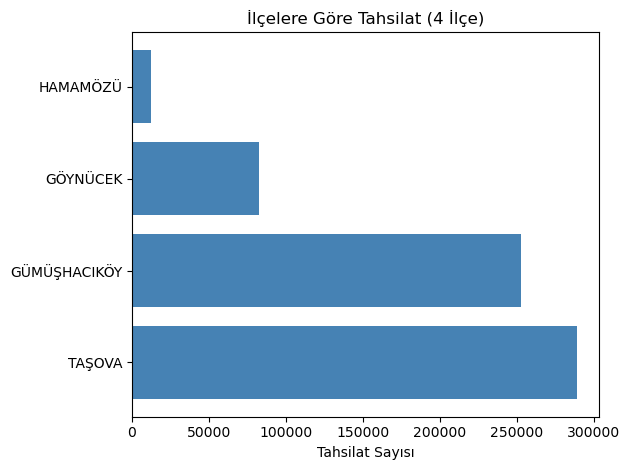

In [104]:
# ============================
# TAHSİLAT - İLÇE DAĞILIMLARI

# Tahsilat verilerindeki kayıt sayısının ilçelere göre dağılımı

ilce_sayilari = df_tahsilat['İlçe'].value_counts() #pandas series with name of ilce is index

plt.barh(ilce_sayilari.index, ilce_sayilari.values, color='steelblue')
plt.title(f'İlçelere Göre Tahsilat ({len(ilce_sayilari)} İlçe)')
plt.xlabel('Tahsilat Sayısı')
plt.tight_layout()

plt.show()

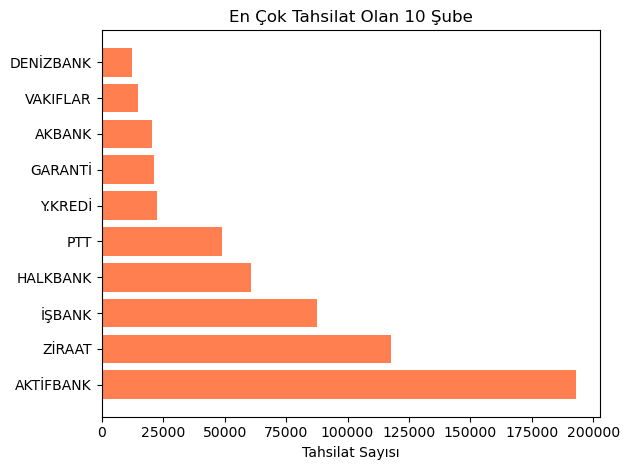

In [106]:
# ============================
# TAHSİLAT - ŞUBE DAĞILIMLARI

# En yüksek işlem hacmine sahip ilk 10 şube

sube_sayilari = df_tahsilat['Şube'].value_counts().head(10) # #pandas series with name of sube is index

plt.barh(sube_sayilari.index, sube_sayilari.values, color='coral')
plt.title('En Çok Tahsilat Olan 10 Şube')
plt.xlabel('Tahsilat Sayısı')

plt.tight_layout()
plt.show()

### Bulgular

Tahsilat işlemlerinin belirli sayıda
şubede yoğunlaştığı görülmektedir.

#### Problem Tanımı

Müşterilerin ödeme davranışlarını inceleyerek zamanında
ve gecikmeli ödeme oranlarının belirlenmesi amaçlanmıştır.

In [280]:
# Zamanında ödeme sütunları
zamaninda_sutunlar = ['Son Ödeme Tarihinden Önceki Tahsilat', 'Son Ödeme Tarihindeki Tahsilat']

In [279]:
# Geç ödeme sütunları
gec_sutunlar = ['Son Ödeme (1)', 'Son Ödeme (2)', 'Son Ödeme (6-10)', 'Son Ödeme (10-20)', 
                'Son Ödeme (20-30)', 'Son Ödeme (30-60)','Son Ödeme (60-90)', 'Son Ödeme (90-120)', 
                'Son Ödeme (120-150)', 'Son Ödeme (150-180)', 'Son Ödeme (180+)']

In [298]:
# Zamanında ve gecikmeli yapılan tahsilatların toplam tutarları
zamaninda_toplam = df_tahsilat_1[zamaninda_sutunlar].sum().sum()
gec_toplam = df_tahsilat_1[gec_sutunlar].sum().sum()

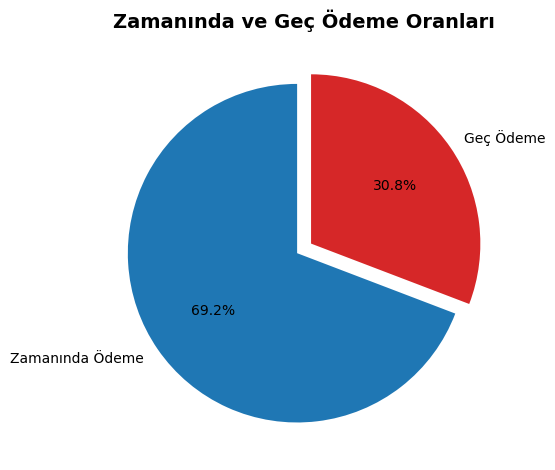

In [144]:
# ================================
#  ZAMANINDA VE GEÇ ÖDEME ORANLARI

# Zamanında ve geç yapılan tahsilat tutarlarının toplam içindeki payı

plt.pie([zamaninda_toplam, gec_toplam], 
        labels=['Zamanında Ödeme', 'Geç Ödeme'],
        autopct='%1.1f%%',
        colors = ["tab:blue","tab:red"],
        explode= [0.05,0.05] ,
        startangle=90,
       )

plt.title('Zamanında ve Geç Ödeme Oranları', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Yukarıdaki analiz, yalnızca **ödeme kaydı bulunan** veriler
üzerinden gerçekleştirilmiştir. Ancak veri seti içerisinde,
herhangi bir tahsilat işleminin henüz gerçekleşmediği
kayıtların da bulunabileceği göz önünde bulundurulmalıdır.

Bu nedenle, tahsilat yapılmayan kayıtların toplam veri seti
içindeki payını değerlendirebilmek amacıyla aşağıda
oransal bir hesaplama yapılmıştır. Bu yaklaşım, tahsilat
sürecinin daha bütüncül ve doğru bir şekilde
yorumlanmasına olanak sağlamaktadır.

In [297]:
# ===================================
# TAHSİLAT YAPILMAYAN KAYIT ORANI

# Tahsilat yapılmayan (sıfır bakiyeli) kayıtların analizi

#Tahsilat_1 veri setindeki ödeme sütunlarının birleştirilmesi
tum_odeme_sutunlari = zamaninda_sutunlar + gec_sutunlar

#Tahsilat_1 veri setindeki ödeme sütunlarındaki her kayıt için toplam tahsilatın hesaplanması ve "toplam_tahsilat" sütuna eklenmesi
df_tahsilat_1['toplam_tahsilat'] = df_tahsilat_1[tum_odeme_sutunlari].fillna(0).sum(axis=1)

# Tahsilat yapılmayan kayıtların belirlenmesi
tahsilat_yok = df_tahsilat_1[df_tahsilat_1['toplam_tahsilat'] == 0]

print("="*50)
print("TAHSİLAT YAPILMAYAN KAYIT ANALİZİ")
print("="*50)
print(f"Toplam kayıt sayısı: {len(df_tahsilat_1):,}")
print(f"Tahsilat yapılmayan kayıt: {len(tahsilat_yok):,}")
print(f"Tahsilat yapılmayan oran: %{(len(tahsilat_yok)/len(df_tahsilat_1)*100):.2f}")
print("-"*50)
print(f"Tahsilat yapılan kayıt: {len(df_tahsilat_1) - len(tahsilat_yok):,}")
print(f"Tahsilat yapılan oran: %{((len(df_tahsilat_1) - len(tahsilat_yok))/len(df_tahsilat_1)*100):.2f}")
print("="*50)

TAHSİLAT YAPILMAYAN KAYIT ANALİZİ
Toplam kayıt sayısı: 917,632
Tahsilat yapılmayan kayıt: 23,422
Tahsilat yapılmayan oran: %2.55
--------------------------------------------------
Tahsilat yapılan kayıt: 894,210
Tahsilat yapılan oran: %97.45


#### Tahsilat Yapılmayan Kayıt Analizi

Toplam 917.632 kayıt üzerinden yapılan incelemede,
23.422 kayıtta herhangi bir tahsilat işleminin
gerçekleşmediği tespit edilmiştir. Bu değer,
toplam kayıtların **%2,55**’ine karşılık gelmektedir.

Buna karşılık, 894.210 kayıtta tahsilat yapılmış olup,
tahsilat gerçekleşen kayıtların oranı **%97,45**’tir.
Bu sonuç, tahakkukların büyük bir bölümünün tahsil
edildiğini ve genel tahsilat performansının yüksek
olduğunu göstermektedir.

In [295]:
df_tahsilat_1.head()

,Mali yıl/dönem,İl,İlçe,Söz.hsp.(bağımsız),Hesap Sınıfı,Tahakkuk Tutar,Son Ödeme Tarihinden Önceki Tahsilat,Son Ödeme Tarihindeki Tahsilat,Son Ödeme (1),Son Ödeme (2),...,Son Ödeme (6-10),Son Ödeme (10-20),Son Ödeme (20-30),Son Ödeme (30-60),Son Ödeme (60-90),Son Ödeme (90-120),Son Ödeme (120-150),Son Ödeme (150-180),Son Ödeme (180+),toplam_tahsilat
0,2023-01-01,AMASYA,GÖYNÜCEK,9374624783,Mesken,5.03,0.03,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,5.03
1,2023-01-01,AMASYA,GÖYNÜCEK,236184905,Mesken,26.46,0.06,26.40,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.46
2,2023-01-01,AMASYA,GÖYNÜCEK,9657731015,Mesken,121.53,NaN,NaN,NaN,121.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.53
3,2023-01-01,AMASYA,GÖYNÜCEK,9554442880,Mesken,117.49,NaN,117.49,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.49
4,2023-01-01,AMASYA,GÖYNÜCEK,6031642522,Mesken,170.30,170.30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.30


### Bulgular

Ödemelerin yüzde **69.2**'lik kısmının **zamanında** yapıldığı,
ancak yüzde **30.8** oranda **gecikmeli** ödeme davranışı
bulunduğu görülmektedir. **Toplam kayıtların %2,55**'ide herhangi bir **tahsilat işleminin gerçekleşmediği** tespit edilmiştir.

#### Problem Tanımı

Elektrik tüketim verilerinde farklı abone gruplarının
tüketim davranışları önemli ölçüde farklılık gösterebilmektedir.
Bu analizde amaç, kWh tüketim değerlerinin dağılımını incelemek,
aşırı uç değerlerin (outlier) varlığını tespit etmek ve bu
değerlerin veri kalitesi veya iş anlamı açısından nasıl
yorumlanması gerektiğini değerlendirmektir.


Aşağıda, tüm veri seti için kWh tüketim dağılımı
histogram ve box plot kullanılarak görselleştirilmiştir.
Box plot üzerinde IQR yöntemine göre belirlenen uç değerler
görülmektedir.

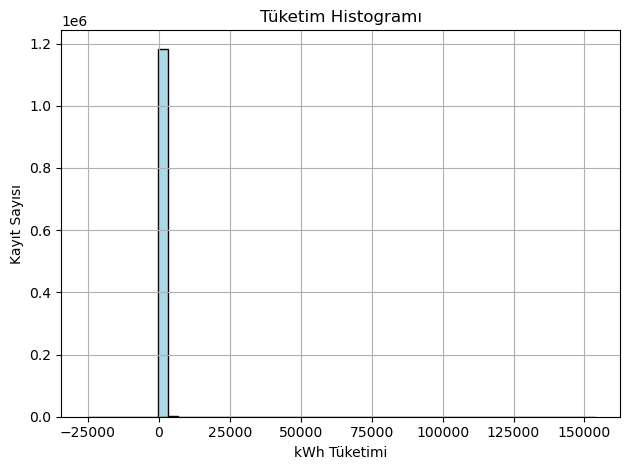

In [158]:
# ===================================
#  kWh TÜKETİM DAĞILIMI - HISTOGRAM 

# Tüketim (kWh) verilerinin dağılımını

# HISTOGRAM (Sütun Grafiği)
plt.hist(df_tahakkuk['kwh'].dropna(),bins= 50 , color='lightblue', edgecolor='black')
plt.title('Tüketim Histogramı')
plt.xlabel('kWh Tüketimi')
plt.ylabel('Kayıt Sayısı')
plt.grid()

plt.tight_layout()
plt.show()


kWh tüketim verisinin dağılımı incelendiğinde,
dağılımın aşırı sağa çarpık olduğu görülmektedir.
Az sayıda yüksek tüketimli abone, histogramın ölçeğini
genişleterek düşük tüketim değerlerinin tek bir aralıkta
yoğunlaşmasına neden olmuştur.

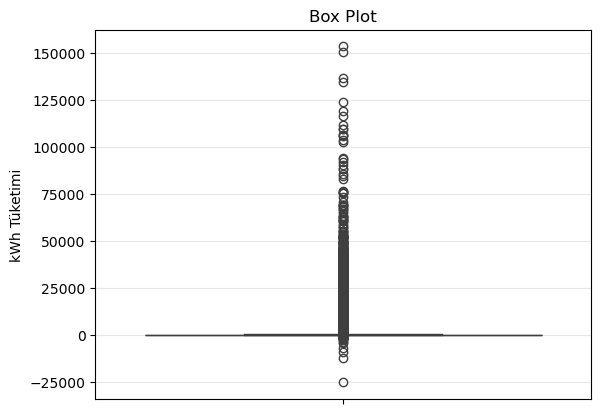

In [235]:
# ================================
# kWh TÜKETİM DAĞILIMI - BOX PLOT

# kWh tüketim verilerindeki aykırı değerleri

# BOX PLOT (Kutu Grafiği)
sns.boxplot(df_tahakkuk['kwh'].dropna())

plt.title('Box Plot')
plt.ylabel('kWh Tüketimi')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [189]:
# IQR (Çeyrekler Arası Aralık) yöntemiyle kWh tüketim verileri için istatistiksel değerlerin hesaplanması

# 1. Önce outlier'ları tespit et
Q1 = df_tahakkuk['kwh'].quantile(0.25)  # Alt çeyrek (%25)
Q3 = df_tahakkuk['kwh'].quantile(0.75)  # Üst çeyrek (%75)
IQR = Q3 - Q1  # Çeyrekler arası fark

# Alt ve üst sınırları hesapla
alt_sinir = Q1 - 1.5 * IQR
ust_sinir = Q3 + 1.5 * IQR

print("="*50)
print("OUTLIER SINIR DEĞERLERİ")
print("="*50)
print(f"Alt sınır: {alt_sinir:.2f} kWh")
print(f"Üst sınır: {ust_sinir:.2f} kWh")
print(f"Q1 (Alt çeyrek): {Q1:.2f} kWh")
print(f"Q3 (Üst çeyrek): {Q3:.2f} kWh")
print(f"IQR: {IQR:.2f} kWh")

OUTLIER SINIR DEĞERLERİ
Alt sınır: -74.97 kWh
Üst sınır: 172.98 kWh
Q1 (Alt çeyrek): 18.01 kWh
Q3 (Üst çeyrek): 80.00 kWh
IQR: 61.99 kWh


In [190]:
# 2. Outlier'ları bul
outlier_olan = df_tahakkuk[(df_tahakkuk['kwh'] < alt_sinir) | 
                            (df_tahakkuk['kwh'] > ust_sinir)]

print(f"\nToplam kayıt sayısı: {len(df_tahakkuk)}")
print(f"Outlier sayısı: {len(outlier_olan)}")
print(f"Outlier oranı: %{(len(outlier_olan)/len(df_tahakkuk)*100):.2f}")


Toplam kayıt sayısı: 1185698
Outlier sayısı: 48554
Outlier oranı: %4.09


#### Tahakkuk Verisi – Outlier Analizi

Tahakkuk veri seti üzerinde yapılan incelemede,
toplam **1.185.698** kayıt içerisinden **48.554** kaydın
uç değer (outlier) olarak sınıflandırıldığı tespit edilmiştir.
Bu değer, toplam kayıtların yaklaşık **%4,09**’una karşılık
gelmektedir.

Outlier oranının görece düşük seviyede olması, tahakkuk
verisinin genel olarak tutarlı bir dağılıma sahip olduğunu
göstermektedir. Bununla birlikte, bu uç değerlerin
belirli hesap sınıflarından ve yüksek tüketim profillerinden
kaynaklandığı daha önceki analizlerde ortaya konmuştur.
Dolayısıyla bu kayıtlar veri hatası olarak değil,
işin doğasından kaynaklanan özel tüketim davranışları
olarak değerlendirilmiştir.

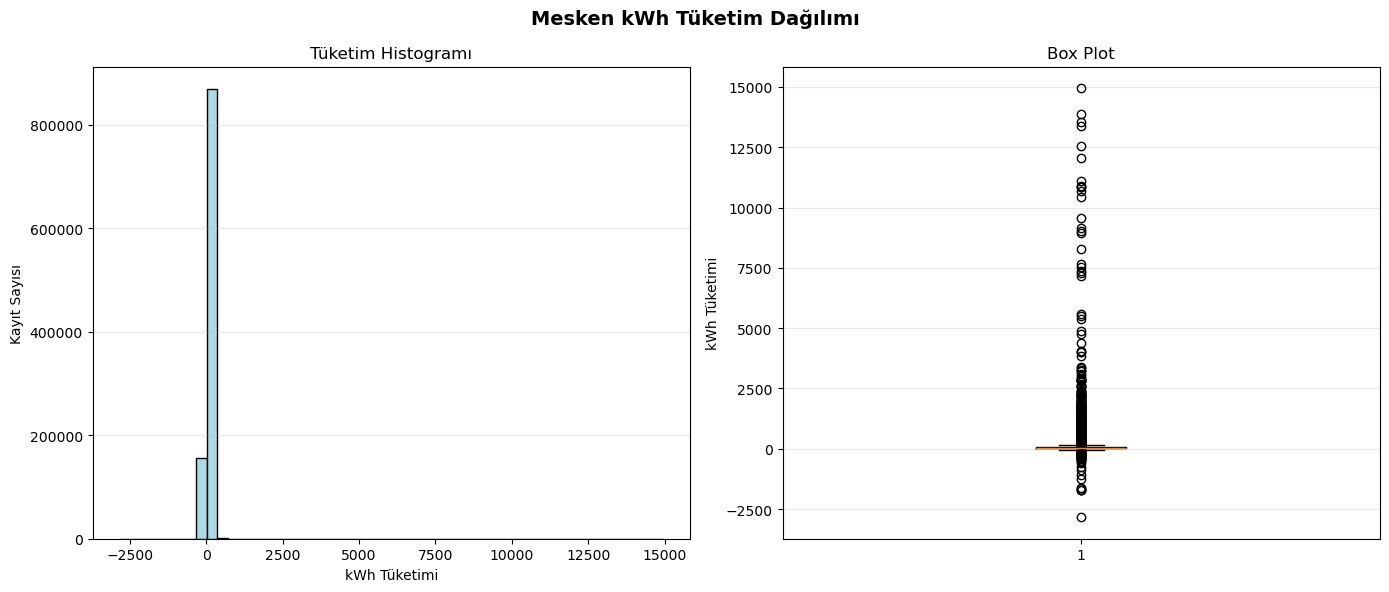

In [237]:
# ============================================================
# kWh TÜKETİM DAĞILIMI - HISTOGRAM VE BOX PLOT - SADECE MESKEN

# Mesken sınıfı için kWh tüketim dağılımını

# Yan yana 2 grafik için alan oluştur 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Mesken kWh Tüketim Dağılımı', fontsize=14, fontweight='bold')

# "Mesken" hesap sınıfına ait verilerin filtrelenmesi
df_hesap_M = df_tahakkuk.loc[
    df_tahakkuk["Hesap Sınıfı"] == "Mesken","kwh"].copy()

# HISTOGRAM (Sütun Grafiği)
axes[0].hist(df_hesap_M, bins=50, color='lightblue', edgecolor='black')
axes[0].set_title('Tüketim Histogramı')
axes[0].set_xlabel('kWh Tüketimi')
axes[0].set_ylabel('Kayıt Sayısı')
axes[0].grid(axis='y', alpha=0.3)

# BOX PLOT (Kutu Grafiği)
axes[1].boxplot(df_hesap_M)
axes[1].set_title('Box Plot')
axes[1].set_ylabel('kWh Tüketimi')
axes[1].grid(axis='y', alpha=0.3)


plt.tight_layout()
plt.show()

In [301]:
# IQR (Çeyrekler Arası Aralık) yöntemiyle kWh tüketim verileri için istatistiksel değerlerin hesaplanması

# 1. Önce outlier'ları tespit et
Q1 = df_hesap_M.quantile(0.25)  # Alt çeyrek (%25)
Q3 = df_hesap_M.quantile(0.75)  # Üst çeyrek (%75)
IQR = Q3 - Q1  # Çeyrekler arası fark

# Alt ve üst sınırları hesapla
alt_sinir = Q1 - 1.5 * IQR
ust_sinir = Q3 + 1.5 * IQR

print("="*50)
print("OUTLIER SINIR DEĞERLERİ")
print("="*50)
print(f"Alt sınır: {alt_sinir:.2f} kWh")
print(f"Üst sınır: {ust_sinir:.2f} kWh")
print(f"Q1 (Alt çeyrek): {Q1:.2f} kWh")
print(f"Q3 (Üst çeyrek): {Q3:.2f} kWh")
print(f"IQR: {IQR:.2f} kWh")


OUTLIER SINIR DEĞERLERİ
Alt sınır: -67.04 kWh
Üst sınır: 165.28 kWh
Q1 (Alt çeyrek): 20.08 kWh
Q3 (Üst çeyrek): 78.16 kWh
IQR: 58.08 kWh


In [302]:
# 2. Outlier'ları bul
outlier_olan_1 = df_hesap_M[(df_hesap_M < alt_sinir) | 
                            (df_hesap_M > ust_sinir)]

print(f"\nToplam kayıt sayısı: {len(df_hesap_M)}")
print(f"Outlier sayısı: {len(outlier_olan_1)}")
print(f"Outlier oranı: %{(len(outlier_olan_1)/len(df_hesap_M)*100):.2f}")


Toplam kayıt sayısı: 1026609
Outlier sayısı: 24994
Outlier oranı: %2.43


#### Tahakkuk Verisi – Mesken Aboneleri Outlier Analizi

Sadece **mesken** hesap sınıfına ait tahakkuk kayıtları
üzerinde yapılan incelemede, toplam **1.026.609** kayıt
içerisinden **24.994** kaydın uç değer (outlier) olarak
sınıflandırıldığı tespit edilmiştir. Bu değer, toplam
mesken kayıtlarının yaklaşık **%2,43**’üne karşılık
gelmektedir.

Genel tahakkuk veri seti ile karşılaştırıldığında,
mesken abonelerine ait outlier oranının daha düşük
olması, bu hesap sınıfındaki tüketim davranışlarının
görece daha homojen olduğunu göstermektedir.

### Bulgular

kWh tüketim dağılımı histogram ve box plot kullanılarak
incelendiğinde, dağılımın belirgin şekilde sağa çarpık olduğu
görülmektedir. Kayıtların büyük bir bölümü düşük tüketim
aralıklarında yoğunlaşırken, az sayıda çok yüksek tüketimli
kayıt ve negatif tüketim değerleri dağılımın ölçeğini
genişletmektedir.

Box plot üzerinde gözlemlenen uç değerlerin önemli bir kısmının,
karayolları aydınlatması, sanayi ve tarımsal faaliyetler gibi
yüksek ve sürekli elektrik tüketimi beklenen hesap sınıflarından
kaynaklandığı tespit edilmiştir. Bu durum, genel dağılımda
görülen outlier’ların veri hatasından ziyade abone türlerinin
yapısal özellikleriyle ilişkili olduğunu göstermektedir.

Bu gözlemi derinleştirmek amacıyla mesken hesap sınıfı ayrı
olarak analiz edilmiş; mesken sınıfına ait histogram ve box plot
grafiklerinin de genel veri setine benzer şekilde sağa çarpık
bir dağılım sergilediği görülmüştür. Ayrıca IQR yöntemi ile
belirlenen uç değerlerin, mesken aboneleri içerisinde de
mevcut olduğu tespit edilmiştir.

Bu bulgular, kWh tüketimindeki çarpıklığın yalnızca hesap
sınıfı farklılıklarından kaynaklanmadığını; mesken aboneleri
dahil olmak üzere kullanıcılar arasında heterojen tüketim
davranışlarının bulunduğunu ortaya koymaktadır. Dolayısıyla
dağılımın yapısı, sınıfsal ayrımdan çok bireysel kullanım
alışkanlıkları ve tüketim koşulları ile açıklanabilir.